In [1]:
!pip install datasets

In [2]:
!pip install transformers==4.30

In [3]:
!pip install transformers[torch]

In [4]:
!pip install accelerate -U

In [5]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
import tqdm

from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from datasets import Dataset
from transformers import ViTImageProcessor, ViTModel

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Get the path to the data folder
path = '/content/drive/MyDrive/AI Project /Data/garbage_classification/'

In [8]:
# Get all the folders in Garbage Classification
folders = os.listdir(path)

In [9]:
folders

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'paper',
 'metal',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [10]:
# Create a dictionary to store the image filenames
filenames = {i:[] for i in folders}
filenames

{'battery': [],
 'biological': [],
 'brown-glass': [],
 'cardboard': [],
 'clothes': [],
 'green-glass': [],
 'paper': [],
 'metal': [],
 'plastic': [],
 'shoes': [],
 'trash': [],
 'white-glass': []}

In [11]:
# Collect the filenames for each image in each folder
for folder in folders:
    files = os.listdir(path + folder + '/')
    filenames[folder].extend(files)

In [12]:
# For each folder, create an array of size(files) for the class label
all_folders = []
all_files = []
all_labels = []

for i in range(len(folders)):
  # Set the number of reps for the labels and folders
  reps = len(filenames[folders[i]])

  # Gather the labels
  labels = [i for j in range(reps)]

  # Create a list to store the folders
  folder_names = [folders[i] for j in range(reps)]

  # Append the folders, files and labels to the lists
  all_folders.extend(folder_names)
  all_files.extend(filenames[folders[i]])
  all_labels.extend(labels)

In [13]:
# Create a dataframe with the labeled data
df = pd.DataFrame({'folder': all_folders, 'filename': all_files, 'class': all_labels})

In [14]:
# Create a column for the path
df['path'] = path + df['folder'] + '/' + df['filename']
df

,folder,filename,class,path
0,battery,battery108.jpg,0,/content/drive/MyDrive/AI Project /Data/garbag...
1,battery,battery116.jpg,0,/content/drive/MyDrive/AI Project /Data/garbag...
2,battery,battery113.jpg,0,/content/drive/MyDrive/AI Project /Data/garbag...
3,battery,battery110.jpg,0,/content/drive/MyDrive/AI Project /Data/garbag...
4,battery,battery122.jpg,0,/content/drive/MyDrive/AI Project /Data/garbag...
...,...,...,...,...
15505,white-glass,white-glass68.jpg,11,/content/drive/MyDrive/AI Project /Data/garbag...
15506,white-glass,white-glass514.jpg,11,/content/drive/MyDrive/AI Project /Data/garbag...
15507,white-glass,white-glass521.jpg,11,/content/drive/MyDrive/AI Project /Data/garbag...
15508,white-glass,white-glass45.jpg,11,/content/drive/MyDrive/AI Project /Data/garbag...


clothes3842.jpg


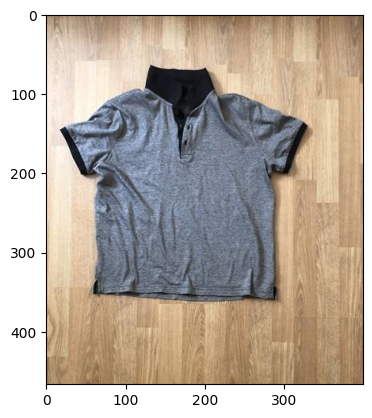

In [15]:
# Load an image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = load_img(sample['path'])
print(sample['filename'])
plt.imshow(randomimage)

In [16]:
type(randomimage)

PIL.JpegImagePlugin.JpegImageFile

# Data-Preprocessing

In [17]:
# Convert the pandas dataframe to a HuggingFace Dataset
dataset = Dataset.from_pandas(df[['path', 'class']])

In [18]:
# Show the features of the dataset
dataset.features

{'path': Value(dtype='string', id=None),
 'class': Value(dtype='int64', id=None)}

In [19]:
# Change the type of 'class' to ClassLabel
dataset = dataset.class_encode_column('class')

Stringifying the column:   0%|          | 0/15510 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/15510 [00:00<?, ? examples/s]

# Train-Test Split

Split the dataset using a 70:15:15 train:validation:test ratio, with stratify_by_column = 'class' to ensure class balances in each set.

In [20]:
# Split dataset into a train and a test set
dataset = dataset.train_test_split(test_size=0.15, stratify_by_column='class')

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'class'],
        num_rows: 13183
    })
    test: Dataset({
        features: ['path', 'class'],
        num_rows: 2327
    })
})

In [22]:
# Split the training data to a train and validation set
train_ds = dataset['train'].train_test_split(test_size=0.15, stratify_by_column='class')

In [23]:
# Show the training dataset
train_ds

DatasetDict({
    train: Dataset({
        features: ['path', 'class'],
        num_rows: 11205
    })
    test: Dataset({
        features: ['path', 'class'],
        num_rows: 1978
    })
})

## Process images with ViTImageProcessor

In [24]:
# Store the ViT model name and load image processor
model_name = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [25]:
print(processor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



Example of processing 1 image:

In [26]:
# Process an image (output is a dictionary with key 'pixel_values', value: tensor)
img_tensor = processor(randomimage, return_tensors="pt")

In [27]:
# Get the tensor shape
img_tensor['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [28]:
# Create a function to apply the image processor to the whole dataset
def process_images(batch):
  """Given a batch of images, return a batch of processed images
  """

  # Get the PIL image given the path
  batch['image'] = [Image.open(path).convert('RGB') for path in batch['path']]

  # Get the new pixel values by processing the image (returns a dict)
  new_ds = processor([x for x in batch['image']], return_tensors='pt')

  # Add the class labels to the new dataset (ds)
  new_ds['class'] = batch['class']

  return new_ds

In [29]:
# Apply the process_images to the training dataset
processed_ds = train_ds.with_transform(process_images)

In [30]:
# Apply the process_images to just the training dataset
processed_train = train_ds['train'].with_transform(process_images)

In [31]:
# Apply the process_images to just the validation dataset
processed_val = train_ds['test'].with_transform(process_images)

In [32]:
# Show the first record in the training set
processed_ds['train'][0]

{'pixel_values': tensor([[[ 0.3961,  0.4118,  0.4431,  ...,  0.3804,  0.3804,  0.3882],
          [ 0.4275,  0.4431,  0.4667,  ...,  0.3804,  0.3804,  0.3882],
          [ 0.4510,  0.4588,  0.4745,  ...,  0.3804,  0.3804,  0.3882],
          ...,
          [-0.3176, -0.3098, -0.2941,  ...,  0.2471,  0.2392,  0.2392],
          [-0.3333, -0.3255, -0.3098,  ...,  0.2471,  0.2471,  0.2392],
          [-0.3412, -0.3333, -0.3176,  ...,  0.2392,  0.2392,  0.2314]],
 
         [[ 0.3725,  0.3882,  0.4196,  ...,  0.3569,  0.3569,  0.3647],
          [ 0.4039,  0.4196,  0.4431,  ...,  0.3569,  0.3569,  0.3647],
          [ 0.4275,  0.4353,  0.4510,  ...,  0.3569,  0.3569,  0.3647],
          ...,
          [-0.3333, -0.3255, -0.3098,  ...,  0.2078,  0.2000,  0.1922],
          [-0.3333, -0.3255, -0.3098,  ...,  0.2000,  0.2000,  0.1922],
          [-0.3412, -0.3333, -0.3176,  ...,  0.1922,  0.1922,  0.1843]],
 
         [[ 0.2392,  0.2549,  0.2863,  ...,  0.2235,  0.2235,  0.2314],
          [ 

In [33]:
# Print the shape of the pixel values when you process 1 image
processed_ds['train'][:1]['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [34]:
# Print the shape of the pixel values when you process 1 image in the train_ds
processed_train[:1]['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [35]:
processed_ds

DatasetDict({
    train: Dataset({
        features: ['path', 'class'],
        num_rows: 11205
    })
    test: Dataset({
        features: ['path', 'class'],
        num_rows: 1978
    })
})

# Model Training

### Data Collector

In [36]:
import torch

In [37]:
# Create a function to return a batch in the format of a dict
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['class'] for x in batch])
    }

### Evaluation Metrics

In [38]:
from datasets import load_metric

In [39]:
metric = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(p):
  return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-39-4dcd9154195d>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


## Load Pre-Trained ViT

In [40]:
from transformers import ViTForImageClassification

In [41]:
# Get the label classes from our dataset
labels = dataset['train'].features['class'].names

In [42]:
# Create ViT model with labels from our dataset
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): label for i, label in enumerate(labels)},
    label2id={label: i for i, label in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define TrainingArguments

In [43]:
from transformers import TrainingArguments
from transformers import Trainer

In [44]:
import transformers
import torch
import accelerate

print("Transformers version:", transformers.__version__)
print("Torch version:", torch.__version__)
print("Accelerate version:", accelerate.__version__)

Transformers version: 4.30.0
Torch version: 2.2.1+cu121
Accelerate version: 0.29.3


In [45]:
#!pip install accelerate==0.20.3

In [46]:
#!pip install transformers==4.30

# Train

In [47]:
metric = load_metric("accuracy", trust_remote_code=True)
from sklearn.metrics import accuracy_score

def compute_metrics(p):
  references = p.label_ids
  predictions = np.argmax(p.predictions, axis=1)
  accuracy = accuracy_score(references, predictions)

    # Save predictions and references for further analysis if needed
  with open("predictions.txt", "w") as f:
    for pred, ref in zip(predictions, references):
      f.write(f"Prediction: {pred}, True Label: {ref}\n")
  return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [48]:
training_args = TrainingArguments(
  output_dir="./ViT_garbage_classification",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [49]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = processed_ds['train'],
    eval_dataset = processed_ds['test'],
    tokenizer = processor,
    compute_metrics = compute_metrics,
    data_collator = collate_fn
)

In [50]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.531000,0.424381,0.907988
200,0.421200,0.309944,0.922144
300,0.238000,0.265536,0.930233
400,0.292500,0.204794,0.945905
500,0.150300,0.183823,0.949949
600,0.174500,0.179983,0.952477
700,0.169600,0.189318,0.947422
800,0.067400,0.143438,0.962588
900,0.153300,0.118691,0.972700
1000,0.040800,0.130189,0.968150


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 3234951072GF
  train_loss               =       0.1238
  train_runtime            =   1:05:06.65
  train_samples_per_second =       11.473
  train_steps_per_second   =        0.718


# Eval

In [51]:
metrics = trainer.evaluate(processed_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9833
  eval_loss               =      0.078
  eval_runtime            = 0:00:40.49
  eval_samples_per_second =     48.846
  eval_steps_per_second   =      6.124


# Eval on Test Set

In [52]:
# Process the test set
processed_full_test = dataset['test'].with_transform(process_images)

In [53]:
# Evaluate the model on the test set
eval_metrics = trainer.evaluate(processed_full_test)
trainer.log_metrics("eval", eval_metrics)
trainer.save_metrics("eval", eval_metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9751
  eval_loss               =     0.1163
  eval_runtime            = 0:03:00.25
  eval_samples_per_second =     12.909
  eval_steps_per_second   =      1.614


In [61]:
import pandas as pd

class_folder_mapping = {}
for idx, row in df.iterrows():
    class_folder_mapping[row['class']] = row['folder']

def read_predictions_file(file_path):
    class_counts = {}  # Dictionary to store counts for each class
    class_correct_counts = {}  # Dictionary to store correct counts for each class


    # Map numerical class labels to folder names
    df['folder'] = df['class'].map(class_folder_mapping)

    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            # Extract prediction and true label from the line
            prediction = int(line.split("Prediction: ")[1].split(",")[0].strip())
            true_label = int(line.split("True Label: ")[1].strip())
            # Increment count for the class
            class_counts[true_label] = class_counts.get(true_label, 0) + 1
            # Increment correct count if prediction matches true label
            if prediction == true_label:
                class_correct_counts[true_label] = class_correct_counts.get(true_label, 0) + 1

    print("Accuracy for each class:")
    for true_label, correct_count in class_correct_counts.items():
        total_count = class_counts[true_label]
        accuracy = correct_count / total_count if total_count != 0 else 0
        print(f"Class {class_folder_mapping[true_label]}: {accuracy * 100:.2f}% ({correct_count}/{total_count})")

    print(f"Total lines read: {len(lines)}")

    return df

# Example usage (assuming "predictions.txt" is the file name)
predictions_df = read_predictions_file("predictions.txt")

Accuracy for each class:
Class clothes: 98.90% (90/91)
Class plastic: 98.09% (154/157)
Class cardboard: 93.97% (109/116)
Class white-glass: 97.31% (289/297)
Class paper: 98.25% (784/798)
Class trash: 92.31% (120/130)
Class biological: 100.00% (148/148)
Class battery: 96.48% (137/142)
Class green-glass: 96.27% (129/134)
Class metal: 98.94% (93/94)
Class shoes: 98.26% (113/115)
Class brown-glass: 98.10% (103/105)
Total lines read: 2327


In [57]:
len(dataset['test'])

2327